In [ ]:
import torch
import numpy as np
import secrets
import matplotlib.pyplot as plt


# Simulation params
NUMBER_OF_NEURONS_TO_SCORE = 256

# SN48 Params
TOP_TIER_PCT = 0.1
NEXT_TIER_PCT = 0.4
TOP_TIER_WEIGHT = 0.7
NEXT_TIER_WEIGHT = 0.2
BOTTOM_TIER_WEIGHT = 0.1


In [ ]:
class SN48InputData():
    scores: list[float]

    @classmethod
    def new(cls):
        scores = []
        for _ in range(NUMBER_OF_NEURONS_TO_SCORE):
            scores.append(np.random.random())
        return cls(scores=scores)

    def __init__(self, scores: list[float]):
        self.scores = scores

    def to_tensor(self):
        return torch.tensor(self.scores, dtype=torch.float32)

    def to_circuit(self):
        return {
            "scores": torch.tensor(self.scores, dtype=torch.float32),
            "top_tier_pct": torch.tensor([TOP_TIER_PCT], dtype=torch.float32),
            "next_tier_pct": torch.tensor([NEXT_TIER_PCT], dtype=torch.float32),
            "top_tier_weight": torch.tensor([TOP_TIER_WEIGHT], dtype=torch.float32),
            "next_tier_weight": torch.tensor([NEXT_TIER_WEIGHT], dtype=torch.float32),
            "bottom_tier_weight": torch.tensor([BOTTOM_TIER_WEIGHT], dtype=torch.float32),
            "nonce": torch.tensor([secrets.randbits(32)], dtype=torch.int64)
        }

    def to_onnx(self):
        return {
            "scores": np.array(self.scores, dtype=np.float32),
            "top_tier_pct": np.array([TOP_TIER_PCT], dtype=np.float32),
            "next_tier_pct": np.array([NEXT_TIER_PCT], dtype=np.float32),
            "top_tier_weight": np.array([TOP_TIER_WEIGHT], dtype=np.float32),
            "next_tier_weight": np.array([NEXT_TIER_WEIGHT], dtype=np.float32),
            "bottom_tier_weight": np.array([BOTTOM_TIER_WEIGHT], dtype=np.float32),
            "nonce": np.array([secrets.randbits(32)], dtype=np.int64)
        }


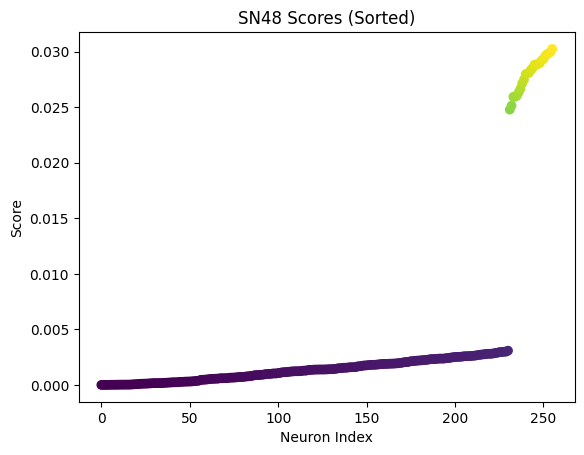

In [ ]:
def calculate_weights( scores):
        n_miners = len(scores)
        sorted_indices = torch.argsort(scores, descending=True)
        weights = torch.zeros(n_miners)

        top_indices, next_indices, bottom_indices = get_tier_indices(sorted_indices, n_miners)

        for indices, weight in [(top_indices, 0.7), (next_indices, 0.2), (bottom_indices, 0.1)]:
            tier_scores = apply_quadratic_scaling(scores[indices])
            weights[indices] = calculate_tier_weights(tier_scores, weight)

        weights /= weights.sum()  # Normalize weights to sum to 1.0
        return weights

def get_tier_indices(sorted_indices, n_miners):
    top_10_pct = max(1, int(0.1 * n_miners))
    next_40_pct = max(1, int(0.4 * n_miners))
    top_indices = sorted_indices[:top_10_pct]
    next_indices = sorted_indices[top_10_pct:top_10_pct + next_40_pct]
    bottom_indices = sorted_indices[top_10_pct + next_40_pct:]
    return top_indices, next_indices, bottom_indices
def apply_quadratic_scaling( scores):
    return scores ** 2
def calculate_tier_weights(tier_scores, total_weight):
    sum_scores = tier_scores.sum()
    if sum_scores > 0:
        return (tier_scores / sum_scores) * total_weight
    else:
        return torch.full_like(tier_scores, total_weight / len(tier_scores))

inputs = SN48InputData.new()

original_scores = calculate_weights(inputs.to_tensor())

sorted_scores = sorted(original_scores)
plt.scatter(range(len(sorted_scores)), sorted_scores, c=sorted_scores, cmap="viridis")
plt.xlabel("Neuron Index")
plt.ylabel("Score")
plt.title("SN48 Scores (Sorted)")
plt.show()

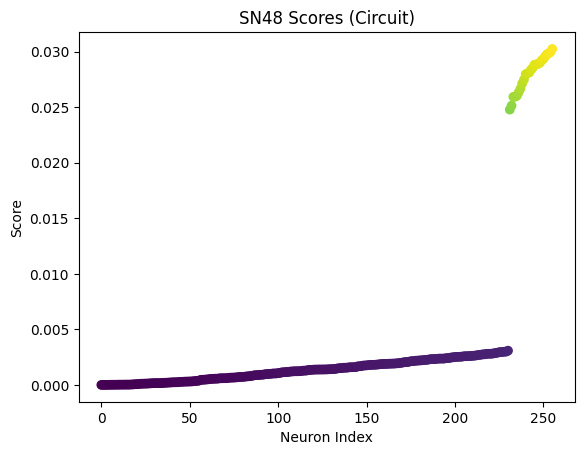

In [ ]:
class Circuit(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.zero = torch.tensor(0.0)
        self.one = torch.tensor(1.0)
        self.two = torch.tensor(2.0)

    def forward(
        self,
        scores,
        top_tier_pct,
        next_tier_pct,
        top_tier_weight,
        next_tier_weight,
        bottom_tier_weight,
        nonce
    ):
        n_miners = scores.shape[0]
        greater_than_count = torch.sum((scores.unsqueeze(1) <= scores.unsqueeze(0)), dim=1)
        rank_indices = greater_than_count - 1
        weights = torch.zeros_like(scores)
        top_10_pct = torch.clamp(top_tier_pct * n_miners, min=self.one).long()
        next_40_pct = torch.clamp(next_tier_pct * n_miners, min=self.one).long()
        top_mask = rank_indices < top_10_pct
        next_mask = torch.logical_and(rank_indices >= top_10_pct,
                                    rank_indices < (top_10_pct + next_40_pct))
        bottom_mask = rank_indices >= (top_10_pct + next_40_pct)
        for mask, weight in [(top_mask, top_tier_weight),
                           (next_mask, next_tier_weight),
                           (bottom_mask, bottom_tier_weight)]:
            tier_scores = torch.where(mask, scores ** self.two, self.zero)
            sum_scores = tier_scores.sum()
            fill_value = weight / mask.sum()
            weights = torch.where(
                mask,
                torch.where(
                    sum_scores > self.zero,
                    (tier_scores / sum_scores) * weight,
                    fill_value.expand_as(scores)
                ),
                weights
            )
        weights = weights / weights.sum()
        return weights, nonce

circuit = Circuit()
modified_scores, _ = circuit(**inputs.to_circuit())

sorted_circuit_scores = sorted(modified_scores)
plt.scatter(range(len(sorted_circuit_scores)), sorted_circuit_scores, c=sorted_circuit_scores, cmap="viridis")
plt.xlabel("Neuron Index")
plt.ylabel("Score")
plt.title("SN48 Scores (Circuit)")
plt.show()

In [ ]:
import os
import json
import onnxruntime as ort
import onnx
import ezkl

def prepare_json_data(inputs):
    return {
        "input_data": [
            inputs["scores"].tolist(),
            inputs["top_tier_pct"].tolist(),
            inputs["next_tier_pct"].tolist(),
            inputs["top_tier_weight"].tolist(),
            inputs["next_tier_weight"].tolist(),
            inputs["bottom_tier_weight"].tolist(),
            inputs["nonce"].tolist()
        ]
    }

input_data = prepare_json_data(inputs.to_circuit())
calibration_data = prepare_json_data(inputs.to_circuit())

with open("input.json", "w") as f:
    json.dump(input_data, f)

with open("calibration.json", "w") as f:
    json.dump(calibration_data, f)

circuit.eval()

input_names = [
    "scores", "top_tier_pct", "next_tier_pct", "top_tier_weight", "next_tier_weight", "bottom_tier_weight", "nonce"

]

torch.onnx.export(
    circuit,
    inputs.to_circuit(),
    "network.onnx",
    input_names=input_names,
    output_names=["weight", "nonce_out"],
    do_constant_folding=True,
    dynamic_axes={
        "top_tier_pct": {0: "batch_size"},
        "next_tier_pct": {0: "batch_size"},
        "top_tier_weight": {0: "batch_size"},
        "next_tier_weight": {0: "batch_size"},
        "bottom_tier_weight": {0: "batch_size"},
        "nonce": {0: "batch_size"},
        "nonce_out": {0: "batch_size"}
    }
)


model = onnx.load("network.onnx")

try:
    onnx.checker.check_model(model, full_check=True)
except onnx.checker.ValidationError as e:
    print(f"The model is invalid: {e}")

session = ort.InferenceSession("network.onnx")
onnx_scores = list(session.run(None, inputs.to_onnx())[0])

# def run_command(command):
#     import subprocess
#     try:
#         subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT, universal_newlines=True)
#     except subprocess.CalledProcessError as e:
#         print(f"Error running {command}:")
#         print(e.output)
#         exit(1)

# commands = [
#     f"ezkl gen-settings --input-visibility=public --param-visibility=fixed",
#     "ezkl calibrate-settings --target=accuracy --scales 20",
#     "ezkl compile-circuit",
#     "ezkl setup",
#     "ezkl gen-witness",
#     # "ezkl prove",
#     # "ezkl verify"
# ]

# for cmd in commands:
#     run_command(cmd)

py_run_args = ezkl.PyRunArgs()
py_run_args.input_visibility = "public"
py_run_args.param_visibility = "fixed"
py_run_args.decomp_legs = 3
ezkl.gen_settings(py_run_args=py_run_args)
ezkl.calibrate_settings(target="accuracy", scales=[20])
for logrows in range(1, 26):
    if not os.path.exists(os.path.expanduser(f"~/.ezkl/srs/kzg{logrows}.srs")):
        print(f"Getting SRS for logrows {logrows}")
        await ezkl.get_srs(logrows=logrows, commitment=ezkl.PyCommitments.KZG)
ezkl.compile_circuit()
ezkl.setup()
ezkl.gen_witness()
# ezkl.prove()
# ezkl.verify()

with open("witness.json", "r") as f:
    witness = json.load(f)

zk_scores = [torch.tensor(float(x), dtype=torch.float32) for x in witness["pretty_elements"]["rescaled_outputs"][0]]

sorted_zk_scores = sorted(zk_scores)
plt.scatter(range(len(sorted_zk_scores)), sorted_zk_scores, c=sorted_zk_scores, cmap="viridis")
plt.xlabel("Neuron Index")
plt.ylabel("Score")
plt.title("SN48 Scores (ZK)")
plt.show()

/workspaces/omron-subnet/.venv/lib/python3.12/site-packages/torch/onnx/symbolic_opset9.py:2056: FutureWarning: 'torch.onnx.symbolic_opset9._cast_Bool' is deprecated in version 2.0 and will be removed in the future. Please Avoid using this function and create a Cast node instead.
  return fn(g, to_cast_func(g, input, False), to_cast_func(g, other, False))
low scale values (<8) may impact precision


RuntimeError: Failed to run setup: [srs] failed to load srs from /home/vscode/.ezkl/srs/kzg17.srs

[tensor] decomposition error: integer 4289973574 is too large to be represented by base 16384 and n 2
forward pass failed: "failed to forward: [halo2] General synthesis error"
[tensor] decomposition error: integer 27048093417472 is too large to be represented by base 16384 and n 2
forward pass failed: "failed to forward: [halo2] General synthesis error"


                                             Score Comparison                                             
┏━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ UID ┃  Original Score ┃ Modified Score ┃ ZK Score ┃ Modified Diff ┃   ZK Diff ┃ ONNX Score ┃ ONNX Diff ┃
┡━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│   0 │        0.002431 │       0.002431 │ 0.002431 │     +0.000000 │ +0.000000 │   0.002431 │ +0.000000 │
│   1 │        0.001855 │       0.001855 │ 0.001855 │     +0.000000 │ +0.000000 │   0.001855 │ +0.000000 │
│   2 │        0.001454 │       0.001454 │ 0.001454 │     +0.000000 │ +0.000000 │   0.001454 │ +0.000000 │
│   3 │        0.002843 │       0.002843 │ 0.002843 │     +0.000000 │ +0.000000 │   0.002843 │ +0.000000 │
│   4 │        0.002752 │       0.002752 │ 0.002751 │     +0.000000 │ +0.000000 │   0.002752 │ +0.000000 │
│   5 │        0.000079 │       0.000079 │ 0.000079 │     +0.000000 │ +0.000000 │   0.000079 │ +0.000000 │
│   6 │        0.001642 │       0.001642 │ 0.001642 │     +0.000000 │ +0.000000 │   0.001642 │ +0.000000 │
│   7 │        0.027441 │       0.027441 │ 0.027441 │     +0.000000 │ +0.000000 │   0.027441 │ +0.000000 │
│   8 │        0.002418 │       0.002418 │ 0.002419 │     +0.000000 │ +0.000000 │   0.002418 │ +0.000000 │
│   9 │        0.002523 │       0.002523 │ 0.002523 │     +0.000000 │ +0.000000 │   0.002523 │ +0.000000 │
│  10 │        0.000012 │       0.000012 │ 0.000012 │     +0.000000 │ +0.000000 │   0.000012 │ +0.000000 │
│  11 │        0.000023 │       0.000023 │ 0.000023 │     +0.000000 │ +0.000000 │   0.000023 │ +0.000000 │
│  12 │        0.001114 │       0.001114 │ 0.001115 │     +0.000000 │ +0.000000 │   0.001114 │ +0.000000 │
│  13 │        0.002916 │       0.002916 │ 0.002915 │     +0.000000 │ +0.000000 │   0.002916 │ +0.000000 │
│  14 │        0.000296 │       0.000296 │ 0.000296 │     +0.000000 │ +0.000000 │   0.000296 │ +0.000000 │
│  15 │        0.003120 │       0.003120 │ 0.003119 │     +0.000000 │ +0.000000 │   0.003120 │ +0.000000 │
│  16 │        0.001770 │       0.001770 │ 0.001770 │     +0.000000 │ +0.000000 │   0.001770 │ +0.000000 │
│  17 │        0.027128 │       0.027128 │ 0.027129 │     +0.000000 │ +0.000001 │   0.027128 │ +0.000000 │
│  18 │        0.000306 │       0.000306 │ 0.000306 │     +0.000000 │ +0.000000 │   0.000306 │ +0.000000 │
│  19 │        0.002408 │       0.002408 │ 0.002408 │     +0.000000 │ +0.000000 │   0.002408 │ +0.000000 │
│  20 │        0.001983 │       0.001983 │ 0.001983 │     +0.000000 │ +0.000000 │   0.001983 │ +0.000000 │
│  21 │        0.000000 │       0.000000 │ 0.000001 │     +0.000000 │ +0.000000 │   0.000000 │ +0.000000 │
│  22 │        0.001228 │       0.001228 │ 0.001228 │     +0.000000 │ +0.000000 │   0.001228 │ +0.000000 │
│  23 │        0.002148 │       0.002148 │ 0.002148 │     +0.000000 │ +0.000000 │   0.002148 │ +0.000000 │
│  24 │        0.000093 │       0.000093 │ 0.000093 │     +0.000000 │ +0.000000 │   0.000093 │ +0.000000 │
│  25 │        0.001362 │       0.001362 │ 0.001363 │     +0.000000 │ +0.000000 │   0.001362 │ +0.000000 │
│  26 │        0.001769 │       0.001769 │ 0.001769 │     +0.000000 │ +0.000000 │   0.001769 │ +0.000000 │
│  27 │        0.003203 │       0.003203 │ 0.003202 │     +0.000000 │ +0.000000 │   0.003203 │ +0.000000 │
│  28 │        0.002138 │       0.002138 │ 0.002137 │     +0.000000 │ +0.000000 │   0.002138 │ +0.000000 │
│  29 │        0.001685 │       0.001685 │ 0.001685 │     +0.000000 │ +0.000000 │   0.001685 │ +0.000000 │
│  30 │        0.001838 │       0.001838 │ 0.001838 │     +0.000000 │ +0.000000 │   0.001838 │ +0.000000 │
│  31 │        0.000299 │       0.000299 │ 0.000299 │     +0.000000 │ +0.000000 │   0.000299 │ +0.000000 │
│  32 │        0.001127 │       0.001127 │ 0.001126 │     +0.000000 │ +0.000000 │   0.001127 │ +0.000000 │
│  33 │        0.002236 │       0.002236 

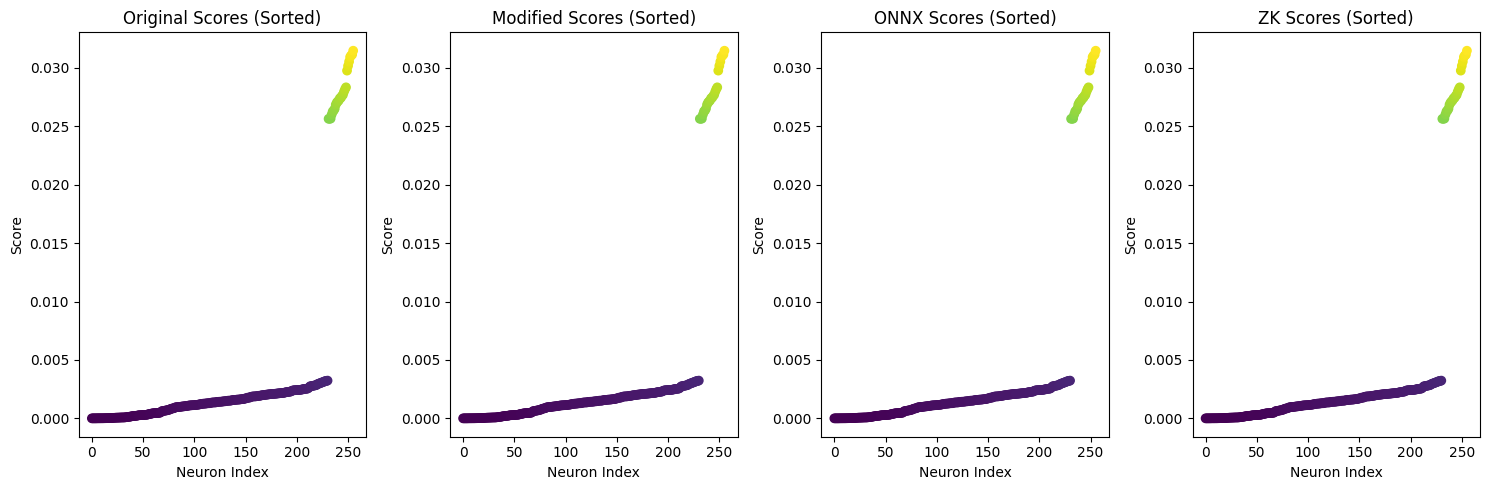


Score Statistics:
Original - Min: 0.000000, Max: 0.031471, Mean: 0.003906
Modified - Min: 0.000000, Max: 0.031471, Mean: 0.003906
ONNX     - Min: 0.000000, Max: 0.031471, Mean: 0.003906
ZK       - Min: 0.000000, Max: 0.031471, Mean: 0.003906


In [ ]:
from rich.console import Console
from rich.table import Table
from typing import Tuple, List
import matplotlib.pyplot as plt
import numpy as np


def create_score_table() -> Tuple[Table, List[Tuple[str, str, str]]]:
    table = Table(title="Score Comparison")
    columns = [
        ("UID", "right", "cyan"),
        ("Original Score", "right", "magenta"),
        ("Modified Score", "right", "green"),
        ("ZK Score", "right", "yellow"),
        ("Modified Diff", "right", "red"),
        ("ZK Diff", "right", "red")
    ]
    return table, columns


def calculate_differences(orig: float, mod: float, zk: float) -> Tuple[float, float, str, str]:
    mod_diff = np.abs(np.float32(mod) - np.float32(orig))
    zk_diff = np.abs(np.float32(zk) - np.float32(orig))
    mod_color = "red" if mod_diff > 1e-5 else "green"
    zk_color = "red" if zk_diff > 1e-5 else "green"
    return mod_diff, zk_diff, mod_color, zk_color


def format_row_data(i: int, orig: float, mod: float, zk: float,
                   mod_color: str, zk_color: str, mod_diff: float, zk_diff: float) -> List[str]:
    return [
        f"{i}",
        f"{orig:.6f}",
        f"{mod:.6f}",
        f"{zk:.6f}",
        f"[{mod_color}]{mod_diff:+.6f}[/{mod_color}]",
        f"[{zk_color}]{zk_diff:+.6f}[/{zk_color}]"
    ]


def plot_scores(scores: List[float], ax: plt.Axes, title: str):
    sorted_scores = sorted(scores)
    ax.scatter(range(len(sorted_scores)), sorted_scores, c=sorted_scores, cmap="viridis")
    ax.set_xlabel("Neuron Index")
    ax.set_ylabel("Score")
    ax.set_title(title)


def print_score_stats(scores: List[float], prefix: str):
    print(f"{prefix:<8} - Min: {min(scores):.6f}, Max: {max(scores):.6f}, "
          f"Mean: {sum(scores)/len(scores):.6f}")


def compare_all_scores(original_scores: List[float], modified_scores: List[float],
                      zk_scores: List[float], onnx_scores: List[float] = None) -> None:
    table, columns = create_score_table()

    if onnx_scores is not None:
        columns.extend([("ONNX Score", "right", "cyan"), ("ONNX Diff", "right", "red")])

    for col, justify, style in columns:
        table.add_column(col, justify=justify, style=style)

    mod_red_count = zk_red_count = 0
    onnx_red_count = 0 if onnx_scores else None
    mod_total_diff = zk_total_diff = 0.0
    onnx_total_diff = 0.0 if onnx_scores else None

    for i, (orig, mod, zk) in enumerate(zip(original_scores, modified_scores, zk_scores)):
        mod_diff, zk_diff, mod_color, zk_color = calculate_differences(orig, mod, zk)
        mod_total_diff += mod_diff
        zk_total_diff += zk_diff
        mod_red_count += mod_color == "red"
        zk_red_count += zk_color == "red"

        row = format_row_data(i, orig, mod, zk, mod_color, zk_color, mod_diff, zk_diff)

        if onnx_scores is not None:
            onnx = onnx_scores[i]
            onnx_diff = np.abs(np.float32(onnx) - np.float32(orig))
            onnx_total_diff += onnx_diff
            onnx_color = "red" if onnx_diff > 1e-6 else "green"
            onnx_red_count += onnx_color == "red"
            row.extend([f"{onnx:.6f}", f"[{onnx_color}]{onnx_diff:+.6f}[/{onnx_color}]"])

        table.add_row(*row)

    total_count = len(original_scores)
    mod_red_percentage = (mod_red_count / total_count) * 100
    zk_red_percentage = (zk_red_count / total_count) * 100
    mod_avg_diff = mod_total_diff / total_count
    zk_avg_diff = zk_total_diff / total_count

    table.add_row("", "", "", "", "", "")
    if onnx_scores is not None:
        table.add_row("", "", "", "", "", "")
        onnx_red_percentage = (onnx_red_count / total_count) * 100
        onnx_avg_diff = onnx_total_diff / total_count
        table.add_row("", "High Loss %:", "", "",
                     f"[red]{mod_red_percentage:.2f}%[/red]",
                     f"[red]{zk_red_percentage:.2f}%[/red]",
                     f"[red]{onnx_red_percentage:.2f}%[/red]")
        table.add_row("", "Avg Difference:", "", "",
                     f"[yellow]{mod_avg_diff:.6f}[/yellow]",
                     f"[yellow]{zk_avg_diff:.6f}[/yellow]",
                     f"[yellow]{onnx_avg_diff:.6f}[/yellow]")
    else:
        table.add_row("", "High Loss %:", "", "",
                     f"[red]{mod_red_percentage:.2f}%[/red]",
                     f"[red]{zk_red_percentage:.2f}%[/red]")
        table.add_row("", "Avg Difference:", "", "",
                     f"[yellow]{mod_avg_diff:.6f}[/yellow]",
                     f"[yellow]{zk_avg_diff:.6f}[/yellow]")

    console = Console()
    console.width = 180
    console.print(table)


compare_all_scores(original_scores, modified_scores, zk_scores, onnx_scores)

if onnx_scores is not None:
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(15, 5))
else:
    fig, (ax0, ax1, ax3) = plt.subplots(1, 3, figsize=(15, 5))

plot_scores(original_scores, ax0, "Original Scores (Sorted)")
plot_scores(modified_scores, ax1, "Modified Scores (Sorted)")

if onnx_scores is not None:
    plot_scores(onnx_scores, ax2, "ONNX Scores (Sorted)")

plot_scores(zk_scores, ax3, "ZK Scores (Sorted)")

plt.tight_layout()
plt.show()

print("\nScore Statistics:")
print_score_stats(original_scores, "Original")
print_score_stats(modified_scores, "Modified")
if onnx_scores is not None:
    print_score_stats(onnx_scores, "ONNX")
print_score_stats(zk_scores, "ZK")